In [1]:
import glob
import pickle
import numpy as np
from numpy.polynomial import Polynomial
from scipy import ndimage, signal, interpolate, integrate
#import matplotlib
#matplotlib.use('PDF')
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014, turn_physical_off, MiyamotoNagaiPotential, plotDensities,evaluateDensities,plotPotentials
from galpy.util import bovy_conversion, save_pickles, bovy_coords, bovy_plot
import pal5_util
#import gd1_util
#from gd1_util import R0, V0
#import custom_stripping_df
import seaborn as sns
import astropy.units as u
from galpy import potential
%pylab inline
from matplotlib import cm, pyplot
from galpy.potential import DehnenSmoothWrapperPotential as DehnenWrap
import SCFbar_util

ro=8.
vo=220.

#from matplotlib.ticker import FuncFormatter, NullFormatter

def galcencyl_to_lbd(R,phi,Z,degree=True):
    xyz=bovy_coords.galcencyl_to_XYZ(R,phi,Z)
    lbd=bovy_coords.XYZ_to_lbd(xyz[0],xyz[1],xyz[2],degree=degree)
    return lbd[0], lbd[1], lbd[2]

Populating the interactive namespace from numpy and matplotlib


In [2]:
Ac,As=SCFbar_util.compute_Acos_Asin()

Mbar=10**10.
pat_speed=40.
ang=27.

prog_barpot,prog_nobarpot=SCFbar_util.MWPotentialSCFbar(Mbar,Acos=Ac,Asin=As,pat_speed=pat_speed,fin_phi_deg=ang,t_stream_age=5.,t_on=2.,tgrow=2)

prog_barpot_invert=SCFbar_util.MWPotentialSCFbar_invert(Mbar,Acos=Ac,Asin=As,pat_speed=pat_speed,fin_phi_deg=ang,t_stream_age=5.,t_on=2.,tgrow=2)

barpot,nobarpot=SCFbar_util.MWPotentialSCFbar(Mbar,Acos=Ac,Asin=As,pat_speed=pat_speed,fin_phi_deg=ang,t_stream_age=5.,t_on=2.,tgrow=2)

barpot_invert=SCFbar_util.MWPotentialSCFbar_invert(Mbar,Acos=Ac,Asin=As,pat_speed=pat_speed,fin_phi_deg=ang,t_stream_age=5.,t_on=2.,tgrow=2)

In [3]:
SCFbar_util.sample_perturbed_Pal5(20,barpot,barpot_invert,nobarpot,prog_barpot,prog_barpot_invert,prog_nobarpot)

[-0.08164492 -0.85602995  1.86090019  0.5721954  -0.27905727  0.32872703] 2.5131614212820557
[-0.17131522 -0.80151026  1.80356897  0.57111326 -0.30427054  0.37793287] 2.5131614212820557
[ 0.47555709 -0.56918991  1.49291283  0.83473486  0.08207704  0.36279462] 3.750885230898527
[ 0.22945339 -0.58450403  1.38151226  0.86069664  0.02531548  0.48636607] 3.750885230898527
[-1.08518999  0.3892567   0.91817724 -0.1490673  -0.41733458  0.9350723 ] 1.3424048129323871
[-1.08101329  0.41223603  0.88131104 -0.16246103 -0.40954541  0.94794335] 1.3424048129323871
[-0.66179667  0.40400245 -0.64842108 -0.66497761 -0.36818427  1.06493555] 2.611194974354166
[-0.56726655  0.45745849 -0.79423438 -0.72656688 -0.31261666  0.97001362] 2.611194974354166
[ 1.00449025 -0.35446206  0.65618154  1.04954214  0.13840487 -0.49788752] 2.8689229457656453
[ 0.80428074 -0.3820232   0.74223216  1.13386007  0.08846341 -0.41028505] 2.8689229457656453
[ 0.76060122 -0.67540762 -0.95138377 -0.36441925  0.99360046 -0.17346979] 

In [ ]:
SCFbar_util.sample_perturbed_Pal5(5,barpot,barpot_invert,nobarpot,trailing=False)

# Plot density contours of the barred MW potential to see how the bar evolves, the straight line is at 27 deg to check whether the bar aligns with that today. The view is from the South Galactic Cap.

0.15359452390564263
/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/galpy-1.4.dev0-py3.6-linux-x86_64.egg/galpy/potential/TwoPowerSphericalPotential.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  return (self.a/r)**self.alpha/(1.+r/self.a)**(self.beta-self.alpha)/4./m.pi/self.a**3.

/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/galpy-1.4.dev0-py3.6-linux-x86_64.egg/galpy/potential/SCFPotential.py:201: RuntimeWarning: divide by zero encountered in true_divide
  rho[:,:] = K * ((a*r)**l) / ((r/a)*(a + r)**(2*l + 3.)) * CC[:,:]* (nu.pi)**-0.5

/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/galpy-1.4.dev0-py3.6-linux-x86_64.egg/galpy/potential/SCFPotential.py:201: RuntimeWarning: invalid value encountered in true_divide
  rho[:,:] = K * ((a*r)**l) / ((r/a)*(a + r)**(2*l + 3.)) * CC[:,:]* (nu.pi)**-0.5

/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/galpy-1.4.dev0-py3.6-linux-x86_64.egg/galpy/potential/SCFPo

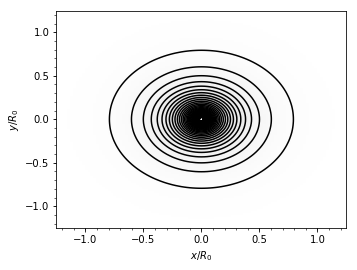

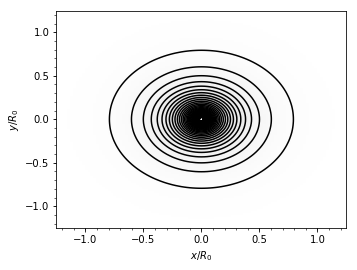

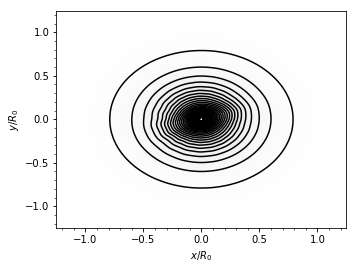

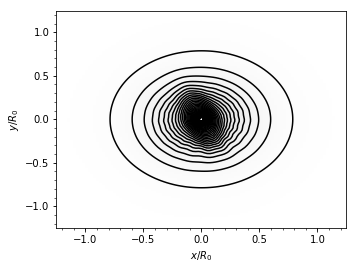

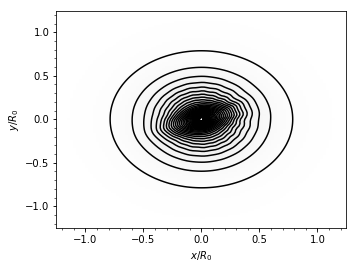

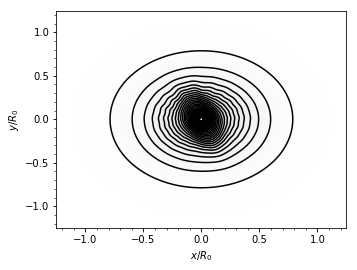

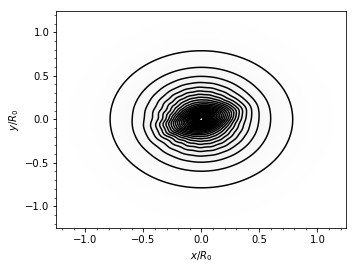

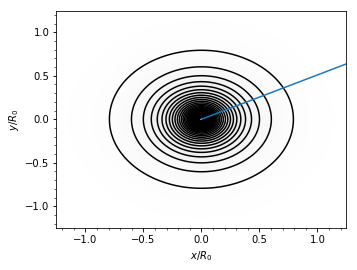

In [3]:
#plot the full MW density contours

# the bar is set 5 Gyrs in the past, positive time takes it forward in time, the bar is 2 Gyr old, so starting at 5 Gyr
# it starts turning on at 3 Gyr

pat_speed=40.
kpc_to_km= 1000*bovy_conversion._PCIN10p18CM*(10**18.)/(10**5.)
Gyr_to_s = 1000.*bovy_conversion._MyrIn1013Sec*10**13.
Tbar1=2.*np.pi/(pat_speed/kpc_to_km)/Gyr_to_s

print (Tbar1)


plotDensities(barpot,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=101,nzs=101,t=(3.-2.2*Tbar1)*u.Gyr,ncontours=80,xy=True)
plotDensities(barpot,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=101,nzs=101,t=(3.-2.*Tbar1)*u.Gyr,ncontours=80,xy=True)
plotDensities(barpot,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=101,nzs=101,t=(3.-Tbar1)*u.Gyr,ncontours=80,xy=True)
plotDensities(barpot,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=101,nzs=101,t=(3.+0.25*Tbar1)*u.Gyr,ncontours=80,xy=True)
plotDensities(barpot,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=101,nzs=101,t=(3.+0.5*Tbar1)*u.Gyr,ncontours=80,xy=True)
plotDensities(barpot,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=101,nzs=101,t=(3.+0.75*Tbar1)*u.Gyr,ncontours=80,xy=True)
plotDensities(barpot,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=101,nzs=101,t=(3.+1.*Tbar1)*u.Gyr,ncontours=80,xy=True)

#present day
plotDensities(barpot,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=101,nzs=101,t=2.*u.Gyr,ncontours=80,xy=True)
plot([0.,10.],[0,10.*np.tan(np.radians(27))])




/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/galpy-1.4.dev0-py3.6-linux-x86_64.egg/galpy/potential/TwoPowerSphericalPotential.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  return (self.a/r)**self.alpha/(1.+r/self.a)**(self.beta-self.alpha)/4./m.pi/self.a**3.

/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/galpy-1.4.dev0-py3.6-linux-x86_64.egg/galpy/potential/SCFPotential.py:201: RuntimeWarning: divide by zero encountered in true_divide
  rho[:,:] = K * ((a*r)**l) / ((r/a)*(a + r)**(2*l + 3.)) * CC[:,:]* (nu.pi)**-0.5

/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/galpy-1.4.dev0-py3.6-linux-x86_64.egg/galpy/potential/SCFPotential.py:201: RuntimeWarning: invalid value encountered in true_divide
  rho[:,:] = K * ((a*r)**l) / ((r/a)*(a + r)**(2*l + 3.)) * CC[:,:]* (nu.pi)**-0.5

/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/galpy-1.4.dev0-py3.6-linux-x86_64.egg/galpy/potential/SCFPotential.py:258: Runt

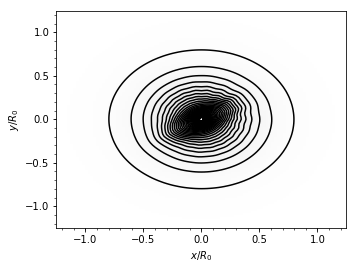

In [7]:
plotDensities(barpot,t=6.*u.Gyr,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=101,nzs=101,ncontours=80,xy=True)

# Plot density contour evolution in the inverted barred MW potential to see how the bar de-evolves, the straight line is at 27 deg to check whether the bar aligns with that today. The view is from the South Galactic Cap.

In [ ]:
#today
plotDensities(barpot_invert,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=101,nzs=101,t=0.*u.Gyr,ncontours=80,xy=True)
plot([0.,10.],[0,10.*np.tan(np.radians(27))])

#0.5 Gyr in the past
plotDensities(barpot_invert,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=101,nzs=101,t=0.1*u.Gyr,ncontours=80,xy=True)
plot([0.,10.],[0,10.*np.tan(np.radians(27))])

#1 Gyr in the past
plotDensities(barpot_invert,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=101,nzs=101,t=1.0*u.Gyr,ncontours=80,xy=True)

plotDensities(barpot_invert,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=101,nzs=101,t=2.*u.Gyr,ncontours=80,xy=True)

plotDensities(barpot_invert,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=101,nzs=101,t=2.02*u.Gyr,ncontours=80,xy=True)

plotDensities(barpot_invert,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=101,nzs=101,t=2.03*u.Gyr,ncontours=80,xy=True)

plotDensities(barpot_invert,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=101,nzs=101,t=3.*u.Gyr,ncontours=80,xy=True)

plotDensities(barpot_invert,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=101,nzs=101,t=5.*u.Gyr,ncontours=80,xy=True)


# plot the orbits of Pal 5 progenitor with and without bar

In [3]:
tpal5age = 5. # Gyr

#time in the past from the present
t_back= 5. # in Gyr

t_past=numpy.linspace(0.,t_back,1001)/bovy_conversion.time_in_Gyr(220.,8.)
t_future=numpy.linspace(tpal5age-t_back,tpal5age,1001)/bovy_conversion.time_in_Gyr(220.,8.)


pal5= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,solarmotion=[-11.1,24.,7.25])
#print (pal5._orb.vxvv)

#integrate Pal 5 back and then forward for 5 Gyr in nobarpot to see how well we end up where we started
pal5_nobar= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,solarmotion=[-11.1,24.,7.25]).flip() 
pal5_nobar.integrate(t_past,nobarpot)

print (pal5_nobar(t_past[-1]).flip()._orb.vxvv)

[0.4847439972400515, -0.3202609229484732, 1.0449208997973125, 0.9004229804362026, 0.6443029727087987, 4.962798388966622]


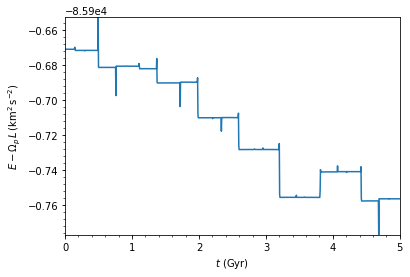

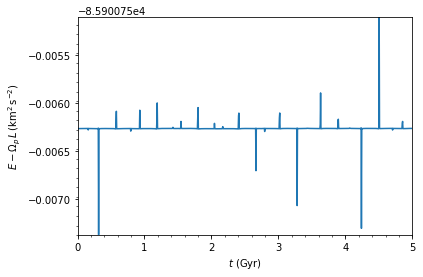

In [4]:
#pal5_nobar.plotE()
pal5_nobar.plot(d1='t',d2='Jacobi')

pal5_nobar_init=pal5_nobar(t_past[-1]).flip()._orb.vxvv
p5nobar=Orbit(pal5_nobar_init,ro=ro,vo=vo)
p5nobar.integrate(t_future,nobarpot)


#p5nobar.plotE(normed=True)
p5nobar.plot(d1='t',d2='Jacobi')
#print (p5nobar(t_future[-1])._orb.vxvv)

In [5]:
#integrate Pal 5 back in barpot_invert and then forward for 5 Gyr in the barpot to see how well we end up where we started
pal5_bar= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],ro=ro,vo=vo,radec=True,solarmotion=[-11.1,24.,7.25]).flip() 
pal5_bar.integrate(t_past,barpot_invert)

print (pal5_bar(t_past[-1]).flip()._orb.vxvv)

[0.7016768581679431, -0.6685013573382224, 0.7192699511487576, 0.606253414648977, 0.9301973507248583, 4.34562404963178]


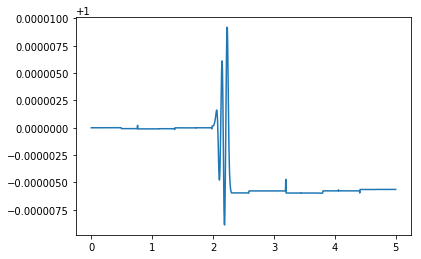

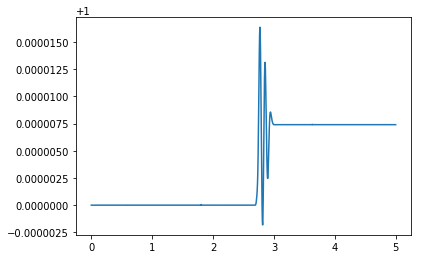

[ 1.03489594 -0.21806694  0.48973606  2.08192774 -0.06107142  3.09783954]


In [6]:
#pal5_bar.plotE(normed=True)
#pal5_bar.plot(d1='t',d2='Jacobi')
plt.figure()
plot(t_past*bovy_conversion.time_in_Gyr(220.,8.),pal5_bar.Jacobi(t_past,OmegaP=-40./vo*ro)/pal5_bar.Jacobi(0.,OmegaP=-40./vo*ro))
plt.show()




pal5_bar_init=pal5_bar(t_past[-1]).flip()._orb.vxvv
p5bar=Orbit(pal5_bar_init,ro=ro,vo=vo)
p5bar.integrate(t_future,barpot)
#p5bar.plotE(normed=True)
#p5bar.plot(d1='t',d2='Jacobi')
plt.figure()
plt.plot(t_future*bovy_conversion.time_in_Gyr(220.,8.),p5bar.Jacobi(t_future,OmegaP=40./vo*ro)/p5bar.Jacobi(0.,OmegaP=40./vo*ro))
plt.show()
print (p5bar(t_future[-1])._orb.vxvv)

In [ ]:
#plot their orbits
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(12,6)

p5bar.plot(d1='x',d2='y',xrange=[-20.,20.],yrange=[-20.,20.],c='k')
p5nobar.plot(d1='x',d2='y',xrange=[-20.,20.],yrange=[-20.,20.],c='r',ls='--',overplot=True)



p5bar.plot(c='k')
p5nobar.plot(c='r',ls='--',overplot=True)

tight_layout()

# check whether pal5 comes to the same location on integrating for a certain time back from today vs integrate all the way back to 5 Gyrs and then integrate forward to that particular time from 5 Gyr in the past

In [ ]:
tpal5age = 5. # Gyr
tage=numpy.linspace(0.,tpal5age,1001)/bovy_conversion.time_in_Gyr(220.,8.)

#time in the past from the present
t_back= 3. # in Gyr

t_past=numpy.linspace(0.,t_back,1001)/bovy_conversion.time_in_Gyr(220.,8.)

t_forward=numpy.linspace(0.,tpal5age-t_back,1001)/bovy_conversion.time_in_Gyr(220.,8.)

t_future=numpy.linspace(tpal5age-t_back,tpal5age,1001)/bovy_conversion.time_in_Gyr(220.,8.)


#pal5= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,solarmotion=[-11.1,24.,7.25])
#print (pal5._orb.vxvv)

#integrate Pal 5 back and then forward for 5 Gyr in nobarpot to see how well we end up where we started
pal5_nobar= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,solarmotion=[-11.1,24.,7.25]).flip() 
pal5_nobar.integrate(t_past,nobarpot)

print (pal5_nobar(t_past[-1]).flip()._orb.vxvv)

pal5_nobar_1= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,solarmotion=[-11.1,24.,7.25]).flip()
pal5_nobar_1.integrate(tage,nobarpot)

pal5_nobar_1=Orbit(pal5_nobar_1(tage[-1]).flip()._orb.vxvv)

pal5_nobar_1.integrate(t_forward,nobarpot)

print (pal5_nobar_1(t_forward[-1])._orb.vxvv)


pal5_bar= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,solarmotion=[-11.1,24.,7.25]).flip() 
pal5_bar.integrate(t_past,barpot_invert)

print (pal5_bar(t_past[-1]).flip()._orb.vxvv)

pal5_bar_1= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,solarmotion=[-11.1,24.,7.25]).flip()
pal5_bar_1.integrate(tage,barpot_invert)

pal5_bar_1=Orbit(pal5_bar_1(tage[-1]).flip()._orb.vxvv)

pal5_bar_1.integrate(t_forward,barpot)

print (pal5_bar_1(t_forward[-1])._orb.vxvv)



# Test integrating orbits upto each stripping time vs using interpolation

In [ ]:
import time

tpal5age = 5. # Gyr
tage=numpy.linspace(0.,tpal5age,1001)/bovy_conversion.time_in_Gyr(220.,8.)

#time in the past from the present
t_back= 3. # in Gyr

t_past=numpy.linspace(0.,t_back,1001)/bovy_conversion.time_in_Gyr(220.,8.)

t_forward=numpy.linspace(0.,tpal5age-t_back,1001)/bovy_conversion.time_in_Gyr(220.,8.)

t_future=numpy.linspace(tpal5age-t_back,tpal5age,1001)/bovy_conversion.time_in_Gyr(220.,8.)

pal5_bar_1= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,solarmotion=[-11.1,24.,7.25]).flip() 
pal5_bar_1.integrate(tage,barpot_invert)

start = time.time()

pal5_bar= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,solarmotion=[-11.1,24.,7.25]).flip() 
pal5_bar.integrate(t_past,barpot_invert)

pal5_bar_orb=pal5_bar(t_past[-1]).flip()._orb.vxvv
print (pal5_bar_orb)
end = time.time()

print (end - start)

start = time.time()
pal5_bar_orb_1=pal5_bar_1(t_past[-1]).flip()._orb.vxvv

print (pal5_bar_orb_1)

end = time.time()

print (end - start)
       


In [ ]:
#coloring stuff

cmap= cm.plasma

def color_from_colormap(val,cmap,cmin,cmax):
    va=[]
    for v in val:
        va.append(cmap((v-cmin)/(cmax-cmin)))
        
    return va

def add_discrete_colorbar_dens(vmin,vmax,clabel,ticks,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.775,0.135,0.05,0.815])
    else:
        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([0.925, 0.13, 0.075, 0.83])
    tcmap = matplotlib.colors.ListedColormap([cmap(f) for f in numpy.linspace(0.,1.,len(ticks))])
    dtick= (ticks[1]-ticks[0])
    sm = pyplot.cm.ScalarMappable(cmap=tcmap,norm=pyplot.Normalize(vmin=vmin-0.5*dtick,vmax=vmax+0.5*dtick))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$',ticks=ticks)
    cbar.set_label(clabel)
    return None

def add_colorbar(vmin,vmax,clabel,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.9,0.135,0.025,0.815])
    else:
        fig.subplots_adjust(right=0.95)
        cbar_ax = fig.add_axes([0.975, 0.13, 0.025, 0.83])
    sm = pyplot.cm.ScalarMappable(cmap=cmap,norm=pyplot.Normalize(vmin=vmin,vmax=vmax))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$')
    cbar.set_label(clabel)
    return None

In [ ]:
#setup Pal 5 smooth stream, only the trailing arm at the moment, for different potentials


sdf_trailing= pal5_util.setup_pal5model(pot=nobarpot)
#sdf_leading= pal5_util.setup_pal5model(pot=nobarpot,leading=True)

#Sample N points from the smooth model today 
N=200
Rt,vRt,vTt,zt,vzt,phit,dtt= sdf_trailing.sample(n=N,returndt=True)
#Rl,vRl,vTl,zl,vzl,phil,dtl= sdf_leading.sample(n=N,returndt=True)
#l,b,d,vlos,pmll,pmbb = sdf_smooth.sample(n=N,lb=True)

#trackRADec_trailing=bovy_coords.lb_to_radec(sdf_trailing._interpolatedObsTrackLB[:,0],
#                          sdf_trailing._interpolatedObsTrackLB[:,1],
#                          degree=True)

#trackRADec_leading=bovy_coords.lb_to_radec(sdf_leading._interpolatedObsTrackLB[:,0],
#                          sdf_leading._interpolatedObsTrackLB[:,1],
#                          degree=True)

#add color label based on time of stripping

#stripping time bins:
t_age= 5. 
dt_bins=np.linspace(0.,t_age,6)
print (dt_bins)

lt_unp=numpy.empty(N)
bt_unp=numpy.empty(N)
dtt_s=numpy.empty(N)

ll_unp=numpy.empty(N)
bl_unp=numpy.empty(N)
dtl_s=numpy.empty(N)

for i in range(N):
    dtt_s[i]=numpy.digitize(dtt[i]*bovy_conversion.time_in_Gyr(220.,8.),dt_bins)
    lt_unp[i]=galcencyl_to_lbd(Rt[i],phit[i],zt[i])[0]
    bt_unp[i]=galcencyl_to_lbd(Rt[i],phit[i],zt[i])[1]
    
    #dtl_s[i]=numpy.digitize(dtl[i]*bovy_conversion.time_in_Gyr(220.,8.),dt_bins)
    #ll_unp[i]=galcencyl_to_lbd(Rl[i],phil[i],zl[i])[0]
    #bl_unp[i]=galcencyl_to_lbd(Rl[i],phil[i],zl[i])[1]
    
radec1t=bovy_coords.lb_to_radec(lt_unp,bt_unp,degree=True) 
#radec1l=bovy_coords.lb_to_radec(ll_unp,bl_unp,degree=True)

In [ ]:
def sample_perturbed_Pal5(N,barpot,barpot_invert,nobarpot,dir='',trailing=True,tpal5age=5.,t_on=2.,tgrow=2,pat_speed=40.):
    #Sample N points from the smooth model today 
    
       
    if trailing :
        R,vR,vT,z,vz,phi,dt= sdf_trailing.sample(n=N,returndt=True)
        fo=open(dir + 'sample_trailing_{}_perturbed_Pal5_{}Gyrbar_{}barperiod_{}pat_speed.dat'.format(N,t_on,tgrow,pat_speed),'w')
        
    else :
        R,vR,vT,z,vz,phi,dt= sdf_leading.sample(n=N,returndt=True)
        fo=open(dir + 'sample_leading_{}_perturbed_Pal5_{}Gyrbar_{}barperiod_{}pat_speed.dat'.format(N,t_on,tgrow,pat_speed),'w')
        
        
    finalR= numpy.empty(N)
    finalvR=numpy.empty(N)
    finalvT=numpy.empty(N)
    finalvz=numpy.empty(N)
    finalphi= numpy.empty(N)
    finalz= numpy.empty(N)
    tt=numpy.empty(N)

    tform = SCFbar_util.tform_from_t_on(t_on=t_on,pat_speed=pat_speed,tgrow=tgrow) #in galpy

    for ii in range(N):
        
        o= Orbit([R[ii],vR[ii],vT[ii],z[ii],vz[ii],phi[ii]]).flip() # flip flips the velocities for backwards integration
        ts= numpy.linspace(0.,dt[ii],1001)
    
        #for integrating in barpot, time starts 5 Gyrs in the past and goes forward
        ts_future= numpy.linspace(tpal5age - dt[ii],tpal5age,1001)
    
        o.integrate(ts,nobarpot)
        unp_orb=ot(ts[-1]).flip()._orb.vxvv
        
        
        
        #integrate Pal 5 progenitor in barpot back from today until the stripping time
        pal5_bar= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,solarmotion=[-11.1,24.,7.25]).flip() 
        pal5_bar.integrate(ts,barpot_invert)
    
        #flip to get correct orbit
        pal5_orb_bar=pal5_bar(ts[-1]).flip()._orb.vxvv
            
        #integrate Pal 5 progenitor in nobarpot back from today until the stripping time    
        pal5_nobar= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,solarmotion=[-11.1,24.,7.25]).flip() 
        pal5_nobar.integrate(ts,nobarpot)
    
        #flip again to get correct velocity of the progenitor
        pal5_orb_nobar=pal5_nobar(ts[-1]).flip()._orb.vxvv
        
        #subtract Pal 5 orb in nobarpot and add Pal 5 orbit in barpot
        pert_orb=(np.array(unp_orb) - np.array(pal5_orb_nobar)) + np.array(pal5_orb_bar)
        #print (list(pert_orb_t))
        #print (unp_orb_t)
        pert_orb=Orbit(list(pert_orb))
        
    
     
        
    
        #forward integrate in barred potential
        pert_orb.integrate(ts_future,barpot)
        finalR[ii]= pert_orb.R(ts_future[-1])
        finalphi[ii]= pert_orb.phi(ts_future[-1])
        finalz[ii]= pert_orb.z(ts_future[-1])
        finalvR[ii]=pert_orb.vR(ts_future[-1])
        finalvT[ii]=pert_orb.vT(ts_future[-1])
        finalvz[ii]=pert_orb.vz(ts_future[-1])
        tt[ii]=dt[ii]
    
        fo.write("#R   phi   z   vR    vT    vz    ts" + "\n")
    
        for jj in range(N):
            fo.write(str(finalR[jj]) + "   " + str(finalphi[jj]) + "   " + str(finalz[jj]) + "   " + str(finalvR[jj]) + "   " + str(finalvT[jj]) + "   " + str(finalvz[jj]) + "   " + str(tt[jj]) + "\n")
        
        fo.close()
    
    
    
    

In [ ]:
sample_perturbed_Pal5(N,barpot,barpot_invert,nobarpot,dir='',trailing=True,tpal5age=5.,t_on=2.,tgrow=2,pat_speed=40.)

In [ ]:
# integrate these N particles *backward* in time to when they were all stripped (they were stripped dt in the past, dt is different for each particle); something like

finalRt= numpy.empty(N)
finalphit= numpy.empty(N)
finalzt= numpy.empty(N)

finalRt1= numpy.empty(N)
finalphit1= numpy.empty(N)
finalzt1= numpy.empty(N)


lt_p=numpy.empty(N)
bt_p=numpy.empty(N)

lt_p1=numpy.empty(N)
bt_p1=numpy.empty(N)

#while incorporating the perturbed Pal 5 progenitor orbit, 
#note that the stars stripped before the bar started to grow
#will not be affected by the bar, so for them use only nobarpot


tpal5age= 5. # Gyr

tform = SCFbar_util.tform_from_t_on() #in galpy

for ii in range(N):
    ot= Orbit([Rt[ii],vRt[ii],vTt[ii],zt[ii],vzt[ii],phit[ii]]).flip() # flip flips the velocities for backwards integration
    tst= numpy.linspace(0.,dtt[ii],1001)
    
    #for integrating in barpot, time starts 5 Gyrs in the past and goes forward
    tst_future= numpy.linspace(tpal5age - dtt[ii],tpal5age,1001)
    
    ot.integrate(tst,nobarpot)
    unp_orb_t=ot(tst[-1]).flip()._orb.vxvv
    #print (dtt[ii],tform)
    if dtt[ii] <= tform :
        
        print ("dtt[ii] <= tform")
        
        #integrate Pal 5 progenitor in barpot back from today until the stripping time
        pal5_bar= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,solarmotion=[-11.1,24.,7.25]).flip() 
        pal5_bar.integrate(tst,barpot_invert)
    
        #flip to get correct orbit
        pal5_orb_bar=pal5_bar(tst[-1]).flip()._orb.vxvv
            
        #integrate Pal 5 progenitor in nobarpot back from today until the stripping time    
        pal5_nobar= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,solarmotion=[-11.1,24.,7.25]).flip() 
        pal5_nobar.integrate(tst,nobarpot)
    
        #flip again to get correct velocity of the progenitor
        pal5_orb_nobar=pal5_nobar(tst[-1]).flip()._orb.vxvv
        
        #subtract Pal 5 orb in nobarpot and add Pal 5 orbit in barpot
        pert_orb_t=(np.array(unp_orb_t) - np.array(pal5_orb_nobar)) + np.array(pal5_orb_bar)
        #print (list(pert_orb_t))
        #print (unp_orb_t)
        pert_orb_t=Orbit(list(pert_orb_t))
        
    else : 
        #print ("dtt[ii] > tform")
        #print (unp_orb_t)
        pert_orb_t = Orbit(unp_orb_t)
    
     
    
    pert_orb_t.integrate(tst_future,barpot)
    finalRt[ii]= pert_orb_t.R(tst_future[-1])
    finalphit[ii]= pert_orb_t.phi(tst_future[-1])
    finalzt[ii]= pert_orb_t.z(tst_future[-1])
    
    
    orbs_t=ot(tst[-1]).flip()
    
    orbs_t.integrate(tst_future,barpot)
    
    finalRt1[ii]= orbs_t.R(tst_future[-1])
    finalphit1[ii]= orbs_t.phi(tst_future[-1])
    finalzt1[ii]= orbs_t.z(tst_future[-1])
    
    #convert to (l,b)   
    lt_p[ii]=galcencyl_to_lbd(finalRt[ii],finalphit[ii],finalzt[ii])[0]
    bt_p[ii]=galcencyl_to_lbd(finalRt[ii],finalphit[ii],finalzt[ii])[1]
    
    lt_p1[ii]=galcencyl_to_lbd(finalRt1[ii],finalphit1[ii],finalzt1[ii])[0]
    bt_p1[ii]=galcencyl_to_lbd(finalRt1[ii],finalphit1[ii],finalzt1[ii])[1]

radecpt=bovy_coords.lb_to_radec(lt_p,bt_p,degree=True)  
radecpt1=bovy_coords.lb_to_radec(lt_p1,bt_p1,degree=True)  

In [ ]:
from decimal import Decimal

plt.figure(figsize=(12,6))
plt.subplot(1,3, 1)
plt.title('%.2E Msun SCF bar grow, perturbed Pal5'%Decimal(Mbar))

plt.scatter(radecpt[:,0],radecpt[:,1],s=2,color=color_from_colormap(dtt_s,cmap,0.,5.))
#plt.plot(trackRADec_trailing[:,0],trackRADec_trailing[:,1],lw=2,c='k',label='unperturbed')

#plt.scatter(radecpl[:,0],radecpl[:,1],s=2,color=color_from_colormap(dtl_s,cmap,0.,5.))
#plt.plot(trackRADec_leading[:,0],trackRADec_leading[:,1],lw=2,c='k')
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')
#plt.xlim(227,275)
#plt.ylim(-0.5,10.)

plt.subplot(1,3, 2)
plt.title('%.2E Msun SCF bar grow, unpertubed Pal5'%Decimal(Mbar))

plt.scatter(radecpt1[:,0],radecpt1[:,1],s=2,color=color_from_colormap(dtt_s,cmap,0.,5.))
#plt.plot(trackRADec_trailing[:,0],trackRADec_trailing[:,1],lw=2,c='k',label='unperturbed')

#plt.scatter(radecpl[:,0],radecpl[:,1],s=2,color=color_from_colormap(dtl_s,cmap,0.,5.))
#plt.plot(trackRADec_leading[:,0],trackRADec_leading[:,1],lw=2,c='k')
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')



plt.subplot(1, 3, 3)
plt.title('No SCF bar')

plt.scatter(radec1t[:,0],radec1t[:,1],s=2,color=color_from_colormap(dtt_s,cmap,0.,5.))
#plt.plot(trackRADec_trailing[:,0],trackRADec_trailing[:,1],lw=2,c='k',label='unperturbed')


#plt.scatter(radec1l[:,0],radec1l[:,1],s=2,color=color_from_colormap(dtl_s,cmap,0.,5.))
#plt.plot(trackRADec_leading[:,0],trackRADec_leading[:,1],lw=2,c='k')
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')
#plt.legend(loc='upper left')
add_colorbar(0.,5.,r'$t_{\rm{strip}}$ (Gyr)')
tight_layout()
#plt.savefig('plots/Pal5_Mbar10_10Msun_patspeed65_barangle27.pdf',format='pdf',dpi=1000,bbox_inches='tight')
plt.show()

#plt.figure()
#plt.scatter(radecpt[:,0],radecpt[:,1],s=2,color=color_from_colormap(dtt_s,cmap,0.,5.))
#plt.xlabel('RA (deg)')
#plt.ylabel('DEC (deg)')

plt.show()

In [ ]:
finalRl= numpy.empty(N)
finalphil= numpy.empty(N)
finalzl= numpy.empty(N)

finalRl1= numpy.empty(N)
finalphil1= numpy.empty(N)
finalzl1= numpy.empty(N)

ll_p=numpy.empty(N)
bl_p=numpy.empty(N)

ll_p1=numpy.empty(N)
bl_p1=numpy.empty(N)


for ii in range(N):   
    #For leading arm
    ol= Orbit([Rl[ii],vRl[ii],vTl[ii],zl[ii],vzl[ii],phil[ii]]).flip() # flip flips the velocities for backwards integration
    tsl= numpy.linspace(0.,dtl[ii],1001)
    ol.integrate(tsl,nobarpot)
    unp_orb_l=ol(tsl[-1]).flip()._orb.vxvv
    
    
    #dtt is time in the past from today, change that to time in the future starting from t_Pal5 dynamic age
    dtl_back=5./bovy_conversion.time_in_Gyr(220.,8.) - dtl[ii]
    
    tsl_back= numpy.linspace(0.,dtl_back,1001)
    
    #integrate back and then forward in nobarpot    
    pal5_nobar= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,solarmotion=[-11.1,24.,7.25]).flip() 
    pal5_nobar.integrate(tpal5,nobarpot)
    
    #flip again to get correct velocity of the progenitor
    pal5_orb_nobar_init=pal5_nobar(tpal5[-1]).flip()._orb.vxvv
    
    P5_nobar=Orbit(pal5_orb_nobar_init)
    P5_nobar.integrate(tst_back,nobarpot)
    P5_nobar_orb=P5_nobar(tst_back[-1])._orb.vxvv
    
    #integrate back and then forward in nobarpot 
    pal5_bar= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,solarmotion=[-11.1,24.,7.25]).flip() 
    pal5_bar.integrate(tpal5,barpot_invert)
    
    #flip again to get correct velocity of the progenitor
    pal5_orb_bar_init=pal5_bar(tpal5[-1]).flip()._orb.vxvv
    
    P5_bar=Orbit(pal5_orb_bar_init)
    P5_bar.integrate(tst_back,barpot)
    P5_bar_orb=P5_bar(tst_back[-1])._orb.vxvv
    
    #subtract Pal 5 orb in nobarpot and add Pal 5 orbit in barpot
    pert_orb_l=(np.array(unp_orb_l) - np.array(P5_nobar_orb)) + np.array(P5_bar_orb)
    
   
    #print (unp_orb)
    #print (list(pert_orb))
    #print (P5_nobar_orb)
    #print (P5_bar_orb)
    
    pert_orb_l=Orbit(list(pert_orb_l))
    
    
    
    pert_orb_l.integrate(tsl,barpot)
    finalRl[ii]= pert_orb_l.R(tsl[-1])
    finalphil[ii]= pert_orb_l.phi(tsl[-1])
    finalzl[ii]= pert_orb_l.z(tsl[-1])
    
    
    orbs_l=ol(tsl[-1]).flip()
    
    orbs_l.integrate(tsl,barpot)
    
    finalRl1[ii]= orbs_l.R(tsl[-1])
    finalphil1[ii]= orbs_l.phi(tsl[-1])
    finalzl1[ii]= orbs_l.z(tsl[-1])
    
    #convert to (l,b)   
    ll_p[ii]=galcencyl_to_lbd(finalRl[ii],finalphil[ii],finalzl[ii])[0]
    bl_p[ii]=galcencyl_to_lbd(finalRl[ii],finalphil[ii],finalzl[ii])[1]
    
    ll_p1[ii]=galcencyl_to_lbd(finalRl1[ii],finalphil1[ii],finalzl1[ii])[0]
    bl_p1[ii]=galcencyl_to_lbd(finalRl1[ii],finalphil1[ii],finalzl1[ii])[1]
    
       
    
radecpl=bovy_coords.lb_to_radec(ll_p,bl_p,degree=True)  
radecpl1=bovy_coords.lb_to_radec(ll_p1,bl_p1,degree=True)  
    


In [ ]:
orbs=orbitst

t_bar_on_Gyr= 1.5 #Gyr in the past 
t_on=t_bar_on_Gyr/bovy_conversion.time_in_Gyr(vo,ro)


for ii in range(N):    
#forward integrate in barred potential
    tst= numpy.linspace(0.,dtt[ii],1001)
    
    orbs[ii].integrate(tst,barpot)
    
    finalRt1[ii]= orbs[ii].R(tst[-1])
    finalphit1[ii]= orbs[ii].phi(tst[-1])
    finalzt1[ii]= orbs[ii].z(tst[-1])
    
    if dtt[ii] > t_on :
        
        tbefore= tst[tst < (dtt[ii]-t_on)]
        #print (tbefore)
        orbitst[ii].integrate(tbefore,nobarpot)
        
        #initialize new orbit 
        neworbitst= orbitst[ii](tbefore[-1])
        
        nt=len(tst[tst >=(dtt[ii]-t_on)])
        tafter=numpy.linspace(0.,t_on,nt)
        #print (tafter)
        neworbitst.integrate(tafter,barpot) 
        
        finalRt[ii]= neworbitst.R(tafter[-1])
        finalphit[ii]= neworbitst.phi(tafter[-1])
        finalzt[ii]= neworbitst.z(tafter[-1])
        
         
    else :
        orbitst[ii].integrate(tst,barpot)
        finalRt[ii]= orbitst[ii].R(tst[-1])
        finalphit[ii]= orbitst[ii].phi(tst[-1])
        finalzt[ii]= orbitst[ii].z(tst[-1])
    '''    
    tsl= numpy.linspace(0.,dtl[ii],1001)
    
    if dtl[ii] > t_on :
        tbefore= tsl[tsl < (dtl[ii]-t_on)]
        orbitsl[ii].integrate(tbefore,nobarpot)
        
        #initialize new orbit 
        neworbitsl= orbitsl[ii](tbefore[-1])
        
        nl=len(tsl[tsl >=(dtl[ii]-t_on)])
        tafter=numpy.linspace(0.,t_on,nl)
        neworbitsl.integrate(tafter,barpot) 
        
        finalRl[ii]= neworbitsl.R(tafter[-1])
        finalphil[ii]= neworbitsl.phi(tafter[-1])
        finalzl[ii]= neworbitsl.z(tafter[-1])
        
         
    else :
        orbitsl[ii].integrate(tsl,barpot)
        finalRl[ii]= orbitsl[ii].R(tsl[-1])
        finalphil[ii]= orbitsl[ii].phi(tsl[-1])
        finalzl[ii]= orbitsl[ii].z(tsl[-1])
        
    '''   
    #convert to (l,b)
    lt_p[ii]=galcencyl_to_lbd(finalRt[ii],finalphit[ii],finalzt[ii])[0]
    bt_p[ii]=galcencyl_to_lbd(finalRt[ii],finalphit[ii],finalzt[ii])[1]
    
    lt_p1[ii]=galcencyl_to_lbd(finalRt1[ii],finalphit1[ii],finalzt1[ii])[0]
    bt_p1[ii]=galcencyl_to_lbd(finalRt1[ii],finalphit1[ii],finalzt1[ii])[1]
    
    #ll_p[ii]=galcencyl_to_lbd(finalRl[ii],finalphil[ii],finalzl[ii])[0]
    #bl_p[ii]=galcencyl_to_lbd(finalRl[ii],finalphil[ii],finalzl[ii])[1]
    
    
radecpt=bovy_coords.lb_to_radec(lt_p,bt_p,degree=True)  
radecpt1=bovy_coords.lb_to_radec(lt_p1,bt_p1,degree=True)  
#radecpl=bovy_coords.lb_to_radec(ll_p,bl_p,degree=True) 
     
        

In [ ]:
t_bar_on_Gyr= 1. #Gyr in the past 
t_on=t_bar_on_Gyr/bovy_conversion.time_in_Gyr(vo,ro)

dtt=2./bovy_conversion.time_in_Gyr(vo,ro)

ts= numpy.linspace(0.,dtt,1001)

orb=[1.,0.1,0.03,0.,0.1,0.] 
orb_nobar=orb.integrate(ts,nobarpot)

tbefore= ts[ts < (dtt[ii]-t_on)]
tafter=tst[tst >=(dtt[ii]-t_on)]
orb_bar=orb.integrate(ts,nobarpot)
    

Mbar=10**10.

ts= numpy.linspace(0,1.,1001)*u.Gyr
def plot_orbit_comparison(o):
    o.integrate(ts,MWPotentialSCFbar(Mbar,pat_speed=35.,fin_phi=27.)[0])
    o.plot(yrange=[-2.,2.],xrange=[0.,9.],gcf=True,c='r')
    o.integrate(ts,MWPotentialSCFbar(Mbar,pat_speed=35.,fin_phi=27.)[1])
    o.plot(overplot=True,gcf=True)
    return None

def plot_orbit_comparisonXY(o):
    o.integrate(ts,MWPotentialSCFbar(Mbar,pat_speed=35.,fin_phi=27.)[0])
    o.plot(d1='x',d2='y',xrange=[-10.,10.],yrange=[-10.,10.],gcf=True,c='r')
    o.integrate(ts,MWPotentialSCFbar(Mbar,pat_speed=35.,fin_phi=27.)[1])
    o.plot(d1='x',d2='y',overplot=True,gcf=True)
    return None


#vxvv=[R,vR,vT,z,vz,phi]

bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(12,6)
subplot(2,2,1)
o= Orbit([1.,0.1,0.03,0.,0.1,0.],ro=ro,vo=vo)
plot_orbit_comparison(o)
subplot(2,2,2)
o= Orbit([1.,0.1,-0.03,0.,0.1,0.],ro=ro,vo=vo)
plot_orbit_comparison(o)
subplot(2,2,3)
o= Orbit([1.,0.05,0.07,0.,0.1,0.],ro=ro,vo=vo)
plot_orbit_comparison(o)
subplot(2,2,4)
o= Orbit([1.,0.05,-0.07,0.,0.1,0.],ro=ro,vo=vo)
plot_orbit_comparison(o)
tight_layout()  

    
    

In [ ]:
for ii in range(N):    
#forward integrate in barred potential
    tst= numpy.linspace(0.,dtt[ii],1001)
    t_before = tst[]
    orbitst[ii].integrate(tst,barpot)
    finalRt[ii]= orbitst[ii].R(tst[-1])
    finalphit[ii]= orbitst[ii].phi(tst[-1])
    finalzt[ii]= orbitst[ii].z(tst[-1])
       
    #leading
    orbitsl[ii].integrate(tsl,barpot)
    finalRl[ii]= orbitsl[ii].R(tsl[-1])
    finalphil[ii]= orbitsl[ii].phi(tsl[-1])
    finalzl[ii]= orbitsl[ii].z(tsl[-1])
    
    
    #convert to (l,b)
    lt_p[ii]=galcencyl_to_lbd(finalRt[ii],finalphit[ii],finalzt[ii])[0]
    bt_p[ii]=galcencyl_to_lbd(finalRt[ii],finalphit[ii],finalzt[ii])[1]
    
    ll_p[ii]=galcencyl_to_lbd(finalRl[ii],finalphil[ii],finalzl[ii])[0]
    bl_p[ii]=galcencyl_to_lbd(finalRl[ii],finalphil[ii],finalzl[ii])[1]
    
    
radecpt=bovy_coords.lb_to_radec(lt_p,bt_p,degree=True)   
radecpl=bovy_coords.lb_to_radec(ll_p,bl_p,degree=True) 

In [ ]:
#check pattern 
pat_speed=40.
kpc_to_km= 1000*bovy_conversion._PCIN10p18CM*(10**18.)/(10**5.)
Gyr_to_s = 1000.*bovy_conversion._MyrIn1013Sec*10**13.
Tbar1=2.*np.pi/(pat_speed/kpc_to_km)/Gyr_to_s

print (2.*np.pi/(pat_speed/kpc_to_km)/Gyr_to_s/bovy_conversion.time_in_Gyr(vo,ro))





In [ ]:
2.*numpy.pi/(40./bovy_conversion.freq_in_kmskpc(220.,8.)*bovy_conversion.freq_in_Gyr(220.,8.))